In [2]:
import os
from pathlib import Path
import numpy as np
import pandas as pd
import torch
from torchvision.ops import nms
import cv2
import matplotlib.pyplot as plt

In [3]:
# -------------------------
# CONFIG
# -------------------------
MODEL_PATH = Path("model/best.torchscript")    # <-- change
IMAGE_PATH = Path("data/2023/Images_by_Site/WS1/2023_WS1_0611_0000_WSCT3021.JPG")        # <-- change
IMG_SIZE   = 640
CONF_THRES = 0.25
IOU_THRES  = 0.50
DEVICE     = "cuda" if torch.cuda.is_available() else "cpu"


In [7]:
# -------------------------
# Helpers: letterbox + scaling
# -------------------------
def letterbox_bgr(img_bgr, new_size=640, color=(114, 114, 114)):
    """Resize with padding to square new_size. Returns (img_lb, r, dw, dh)."""
    h, w = img_bgr.shape[:2]
    r = min(new_size / w, new_size / h)
    nw, nh = int(round(w * r)), int(round(h * r))

    img_resized = cv2.resize(img_bgr, (nw, nh), interpolation=cv2.INTER_LINEAR)
    canvas = np.full((new_size, new_size, 3), color, dtype=np.uint8)

    dw = (new_size - nw) // 2
    dh = (new_size - nh) // 2
    canvas[dh:dh + nh, dw:dw + nw] = img_resized
    return canvas, r, dw, dh

def scale_coords_back(xyxy, r, dw, dh, orig_w, orig_h):
    """Map coords from letterboxed IMG_SIZE space back to original image space."""
    xyxy = xyxy.copy()
    xyxy[:, [0, 2]] = (xyxy[:, [0, 2]] - dw) / r
    xyxy[:, [1, 3]] = (xyxy[:, [1, 3]] - dh) / r
    # clamp
    xyxy[:, [0, 2]] = np.clip(xyxy[:, [0, 2]], 0, orig_w)
    xyxy[:, [1, 3]] = np.clip(xyxy[:, [1, 3]], 0, orig_h)
    return xyxy

def xywh_to_xyxy(xywh):
    """xywh: [cx,cy,w,h] -> xyxy"""
    cx, cy, w, h = xywh.T
    x1 = cx - w / 2
    y1 = cy - h / 2
    x2 = cx + w / 2
    y2 = cy + h / 2
    return np.stack([x1, y1, x2, y2], axis=1)

In [8]:
# -------------------------
# Model output parsing (robust-ish)
# -------------------------
def unwrap_output(out):
    """TorchScript may return Tensor, tuple/list, dict."""
    if isinstance(out, torch.Tensor):
        return out
    if isinstance(out, (list, tuple)) and len(out) > 0:
        return out[0]
    if isinstance(out, dict):
        # common key guesses
        for k in ("detections", "pred", "output", "boxes"):
            if k in out:
                return out[k]
    return out  # fallback

def parse_yolo_output(out, conf_thres=0.25):
    """
    Returns Nx6 numpy array: [x1,y1,x2,y2,conf,cls] in *letterbox pixel space*.
    Handles:
      - (1, 5, N): [x,y,w,h,conf]  (no classes)
      - (1, N, 6) or (N,6): [x1,y1,x2,y2,conf,cls] (assumed)
      - (1, N, 5+C) or (N, 5+C): [cx,cy,w,h,obj, class_probs...]
    """
    out = unwrap_output(out)

    print("DEBUG type(out):", type(out))
    if isinstance(out, torch.Tensor):
        print("DEBUG out.shape:", tuple(out.shape), "dtype:", out.dtype)

    if not isinstance(out, torch.Tensor):
        raise ValueError("Model output is not a Tensor (unexpected TorchScript output).")

    t = out.detach().cpu()

    # ---- Case 1: (1, 5, N)  => (N, 5) with [x,y,w,h,conf]
    if t.ndim == 3 and t.shape[0] == 1 and t.shape[1] == 5:
        t = t[0].T  # (5, N) -> (N, 5)

        arr = t.numpy()
        xywh = arr[:, 0:4]
        conf = arr[:, 4]

        keep = conf >= conf_thres
        xyxy = xywh_to_xyxy(xywh[keep])

        conf_kept = conf[keep].reshape(-1, 1)
        cls_kept  = np.zeros((len(conf_kept), 1), dtype=np.float32)  # single-class export
        det = np.concatenate([xyxy, conf_kept, cls_kept], axis=1)
        return det

    # Squeeze typical batch-first outputs
    if t.ndim == 3 and t.shape[0] == 1:
        t = t[0]

    if t.ndim != 2:
        raise ValueError(f"Unexpected output shape after squeeze: {tuple(t.shape)}")

    # ---- Case 2: already-decoded-ish Nx6
    if 6 <= t.shape[1] <= 10:
        det = t[:, :6].numpy()
        det = det[det[:, 4] >= conf_thres]
        return det

    # ---- Case 3: raw preds Nx(5+C)
    if t.shape[1] > 10:
        arr = t.numpy()
        xywh = arr[:, 0:4]
        obj  = arr[:, 4:5]
        cls_probs = arr[:, 5:]

        cls_ids = np.argmax(cls_probs, axis=1)
        cls_conf = cls_probs[np.arange(len(cls_probs)), cls_ids].reshape(-1, 1)

        conf = (obj * cls_conf).reshape(-1)
        keep = conf >= conf_thres

        xyxy = xywh_to_xyxy(xywh[keep])
        conf_kept = conf[keep].reshape(-1, 1)
        cls_kept  = cls_ids[keep].reshape(-1, 1).astype(np.float32)
        det = np.concatenate([xyxy, conf_kept, cls_kept], axis=1)
        return det

    raise ValueError(f"Could not parse output of shape {tuple(out.shape)}")



# -------------------------
# NMS (optionally class-aware)
# -------------------------
def nms_numpy(dets_xyxy_conf_cls, iou_thres=0.5, class_aware=True):
    """
    dets: Nx6 (x1,y1,x2,y2,conf,cls) in same coordinate space
    returns filtered dets in same format
    """
    if dets_xyxy_conf_cls is None or len(dets_xyxy_conf_cls) == 0:
        return dets_xyxy_conf_cls

    dets = dets_xyxy_conf_cls
    boxes = torch.tensor(dets[:, 0:4], dtype=torch.float32)
    scores = torch.tensor(dets[:, 4], dtype=torch.float32)
    cls    = dets[:, 5].astype(np.int64)

    keep_all = []
    if class_aware:
        for c in np.unique(cls):
            idx = np.where(cls == c)[0]
            k = nms(boxes[idx], scores[idx], iou_thres).cpu().numpy()
            keep_all.extend(idx[k].tolist())
        keep_all = np.array(sorted(keep_all), dtype=int)
    else:
        keep_all = nms(boxes, scores, iou_thres).cpu().numpy()

    return dets[keep_all]


# -------------------------
# Drawing + Visualization
# -------------------------
def draw_dets_on_bgr(img_bgr, dets_xyxy_conf_cls, color=(0, 255, 0)):
    out = img_bgr.copy()
    if dets_xyxy_conf_cls is None:
        return out
    for x1, y1, x2, y2, conf, cls in dets_xyxy_conf_cls:
        p1 = (int(x1), int(y1))
        p2 = (int(x2), int(y2))
        cv2.rectangle(out, p1, p2, color, 2)
        cv2.putText(out, f"{int(cls)} {conf:.2f}", (p1[0], max(0, p1[1]-5)),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)
    return out

DEBUG type(out): <class 'torch.Tensor'>
DEBUG out.shape: (1, 5, 8400) dtype: torch.float32
Saved raw_preds.csv and nms_preds.csv


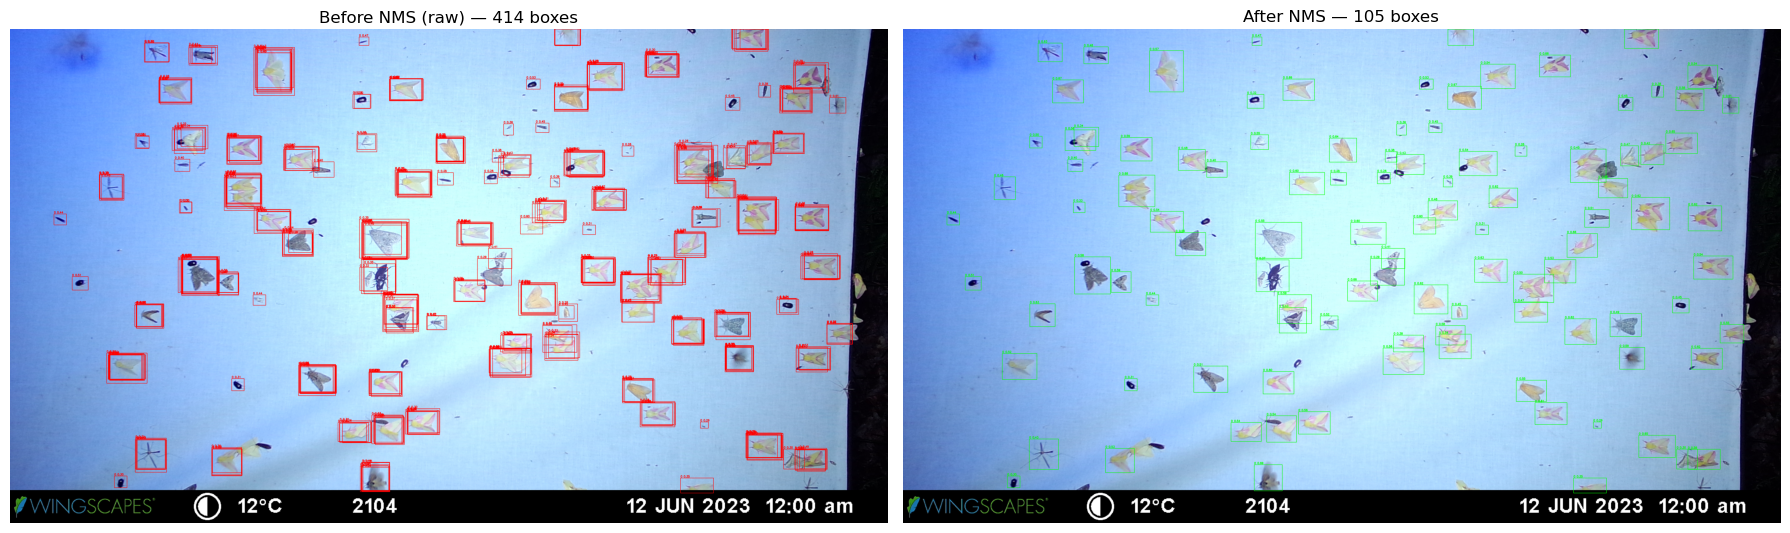

Saved before_after.jpg


In [9]:
# # -------------------------
# # MAIN: inference -> NMS -> side-by-side
# # -------------------------
# def main():
#     # Load model

model = torch.jit.load(str(MODEL_PATH), map_location=DEVICE).eval()

# Load image
img_bgr = cv2.imread(str(IMAGE_PATH))
if img_bgr is None:
    raise FileNotFoundError(f"Could not read image: {IMAGE_PATH}")

orig_h, orig_w = img_bgr.shape[:2]

# Preprocess (letterbox + normalize)
img_lb, r, dw, dh = letterbox_bgr(img_bgr, IMG_SIZE)
x = img_lb[:, :, ::-1].copy()                       # BGR->RGB
x = torch.from_numpy(x).float().permute(2, 0, 1)    # CHW
x = (x / 255.0).unsqueeze(0).to(DEVICE)             # 1x3xHxW

# Inference
with torch.no_grad():
    out = model(x)

raw_dets = parse_yolo_output(out, conf_thres=CONF_THRES)  # Nx6 in letterbox space

# NMS
nms_dets = nms_numpy(raw_dets, iou_thres=IOU_THRES, class_aware=True)

# Map coords back to original image
raw_xyxy = raw_dets[:, 0:4] if len(raw_dets) else np.zeros((0, 4))
nms_xyxy = nms_dets[:, 0:4] if len(nms_dets) else np.zeros((0, 4))

raw_xyxy_orig = scale_coords_back(raw_xyxy, r, dw, dh, orig_w, orig_h)
nms_xyxy_orig = scale_coords_back(nms_xyxy, r, dw, dh, orig_w, orig_h)

raw_dets_orig = raw_dets.copy()
nms_dets_orig = nms_dets.copy()
if len(raw_dets_orig):
    raw_dets_orig[:, 0:4] = raw_xyxy_orig
if len(nms_dets_orig):
    nms_dets_orig[:, 0:4] = nms_xyxy_orig

# Save CSVs
raw_df = pd.DataFrame(raw_dets_orig, columns=["X_Min","Y_Min","X_Max","Y_Max","Confidence","Class"])
nms_df = pd.DataFrame(nms_dets_orig, columns=["X_Min","Y_Min","X_Max","Y_Max","Confidence","Class"])
raw_df.to_csv("initialresults/raw_preds.csv", index=False)
nms_df.to_csv("initialresults/nms_preds.csv", index=False)
print("Saved raw_preds.csv and nms_preds.csv")

# Visualize before/after
before_bgr = draw_dets_on_bgr(img_bgr, raw_dets_orig, color=(0, 0, 255))   # red
after_bgr  = draw_dets_on_bgr(img_bgr, nms_dets_orig, color=(0, 255, 0))   # green

before_rgb = cv2.cvtColor(before_bgr, cv2.COLOR_BGR2RGB)
after_rgb  = cv2.cvtColor(after_bgr,  cv2.COLOR_BGR2RGB)

plt.figure(figsize=(18, 8))
plt.subplot(1, 2, 1)
plt.title(f"Before NMS (raw) — {len(raw_df)} boxes")
plt.imshow(before_rgb)
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title(f"After NMS — {len(nms_df)} boxes")
plt.imshow(after_rgb)
plt.axis("off")

plt.tight_layout()
plt.savefig("before_after.jpg", dpi=200)
plt.show()

print("Saved before_after.jpg")

# if __name__ == "__main__":
#     main()
